## Defining currents

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Polygon, Point, box
from shapely.ops import unary_union
from salishsea_tools import psu_tools

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

IOPATH = '/data/rbeutel/obs/PNW_obs_compiled.csv'

In [2]:
ds = xr.open_dataset("/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/gebco_2023.nc")

In [3]:
obs = pd.read_csv(IOPATH)
obs['current'] = np.nan

grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [4]:
# Salish Sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
# Lat and lon cuttoff
xlim, ylim = [-145.5, -110.2], [25, 57]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [6]:
# Remove Washington Dept of Ecology and ONC data as they consist of river and salish sea data (not offshore so not relevant)
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')

NCEI Salish
464


NCEI Coastal
7808


ios ctd profiles
62649


ios mooring
185224


GEOTRACES IDP21
404


ios bottle, GEOTRACES IDP21
148


ios bottle, NCEI PNW
406


ios bottle
151021


ios mooring, ios bottle
9


ios ctd profiles, ios bottle
766


ios bottle, GEOTRACES Taves
151


NCEI PNW
1376


GEOTRACES Taves
354


CALCOFI
733907


ios bottle, GEOTRACES Anderlini
45


ooi
50567


NHL
603081


ios bottle, GEOTRACES IDP21, GEOTRACES Taves
27


GEOTRACES Anderlini
284


NCEI Coastal, NHL
10


OCNMS
46231


GEOTRACES IDP21, GEOTRACES Taves
12


ios bottle, NCEI PNW, GEOTRACES Taves
3




## Separate shelf, slope, offshore

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

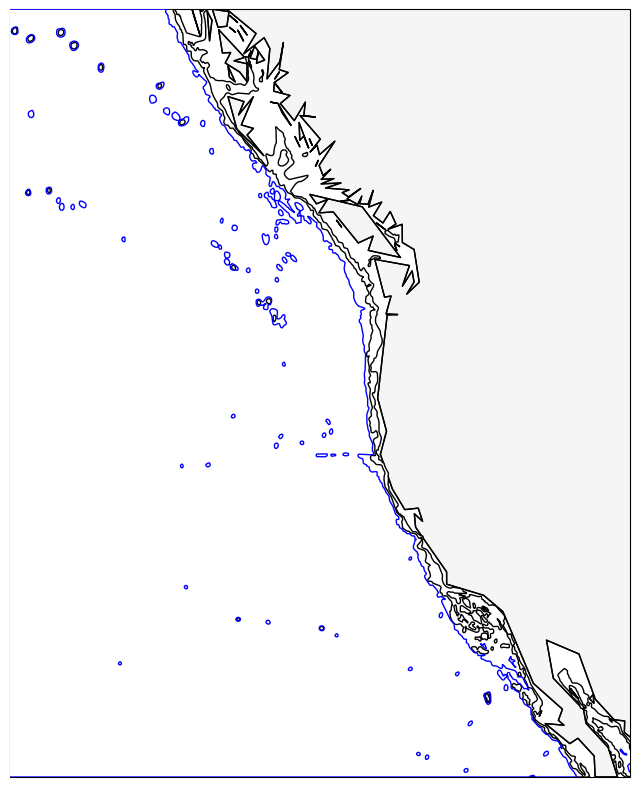

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

elev = ds.elevation
mask = ~((ds.lon > -124.5) & (ds.lon < -122.0) & (ds.lat > 47.5) & (ds.lat < 49.5))
elev_masked = elev.where(mask)

# commented out for now - define shelf as 200 m not 500 m
# # Add custom 500m isobath from GEBCO
# cs = ax.contour(ds.lon, ds.lat, elev_masked, levels=[-500],
#                 colors='r', linewidths=1, transform=crs.PlateCarree(), zorder=5)

In [9]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [10]:
# can we do the same for data between the 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data
# obs_200 = obs_200.to_crs(contour_200m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.unary_union)

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

/tmp/ipykernel_1417886/627789131.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  obs_200['is_slope'] = obs_200.within(contour_200m.unary_union)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

/tmp/ipykernel_1417886/3885089491.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[obs.location=='shelf'] = obs_200['location_type']
/tmp/ipykernel_1417886/3885089491.py:2: SettingWithCopyWarning: 
A value is trying to be set

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

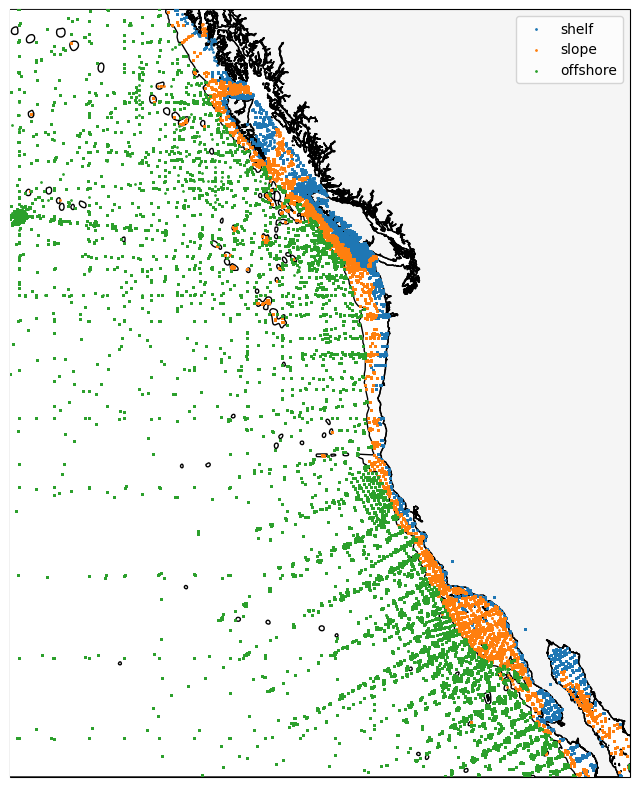

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

ax.legend()

/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cart

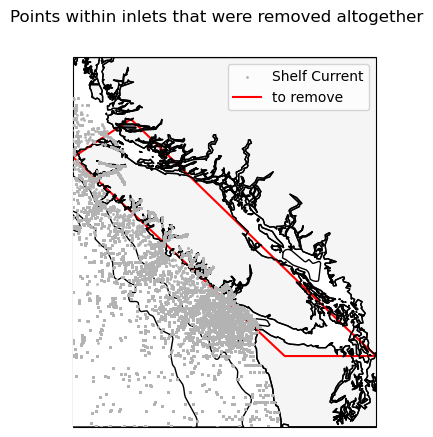

In [13]:
xlim, ylim = [-128.5, -122.2], [47, 52]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'],obs['latitude (degrees_north)'], transform=crs.PlateCarree(),s=1,zorder=5,c='0.7',label='Shelf Current')
# ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')

poly1 = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
ax.plot(poly1[:,0], poly1[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

plt.suptitle('Points within inlets that were removed altogether')

ax.legend()

In [14]:
# inlet mask
polygon1 = Polygon(poly1)
mask1 = obs.apply(lambda row: polygon1.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
print(np.sum(mask1))
obs = obs[~mask1].reset_index(drop=True) # drop these rows completely

32207


/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cart

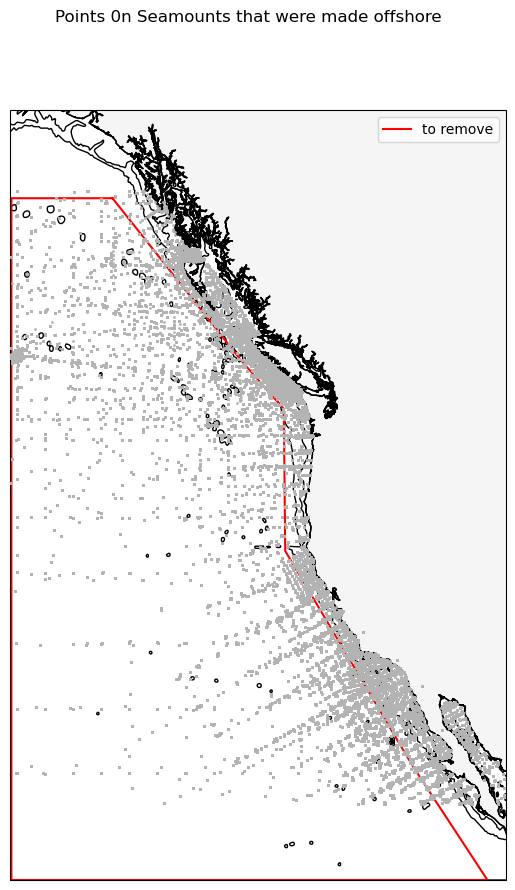

In [15]:
xlim, ylim = [-145.5, -110.2], [20, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'],obs['latitude (degrees_north)'], transform=crs.PlateCarree(),s=1,c='0.7',zorder=5)

poly2 = np.array([[-138.2, 56.7],
         [-126, 47.5],
         [-125.9, 40.2],
         [-111.5, 20],
         [-145.4, 20],
         [-145.4, 56.7],
         [-138.2, 56.7]])
ax.plot(poly2[:,0], poly2[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

plt.suptitle('Points 0n Seamounts that were made offshore')

ax.legend()

In [16]:
# seamount mask
polygon2 = Polygon(poly2)
mask2 = obs.apply(lambda row: polygon2.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
print(np.sum(mask2))
obs.loc[mask2,'location'] = 'offshore' # make these points all offshore values

571151


/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cart

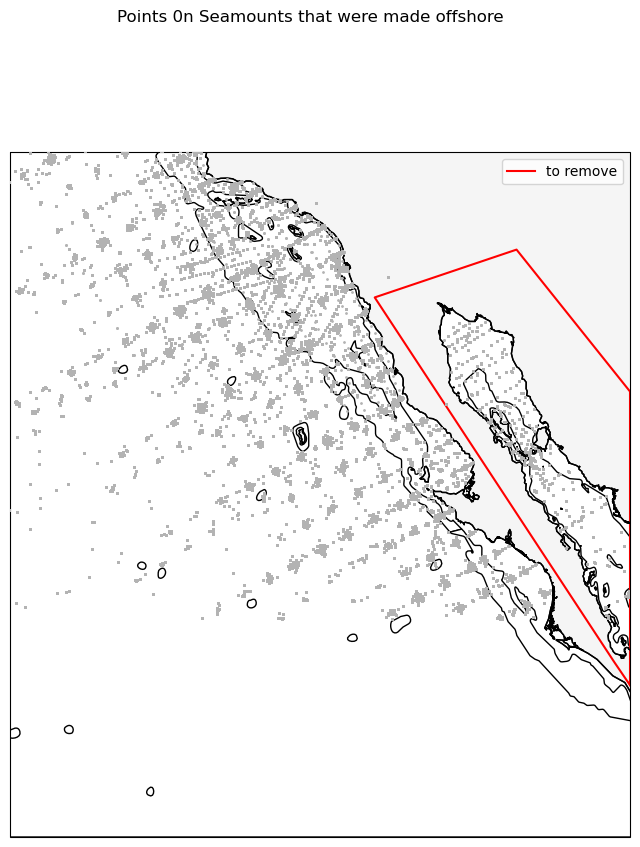

In [17]:
# baja california sea mask

xlim, ylim = [-125.5, -110.2], [20, 35]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'],obs['latitude (degrees_north)'], transform=crs.PlateCarree(),s=1,c='0.7',zorder=5)

poly3 = np.array([[-110.2, 23.5],
         [-110.2, 30],
         [-113, 33],
         [-116.5, 32],
         [-110.2, 23.5]])
ax.plot(poly3[:,0], poly3[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

plt.suptitle('Points 0n Seamounts that were made offshore')

ax.legend()

In [18]:
# seamount mask
polygon3 = Polygon(poly3)
mask3 = obs.apply(lambda row: polygon3.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
print(np.sum(mask3))
obs = obs[~mask3].reset_index(drop=True) # drop these rows completely


7695


In [19]:
# drop all obs

## Shelf Current

In [20]:
# first, removing all points in the obs that don't fulfill the minimum salinity requirement (31.5)
obs = obs[obs['salinity (g kg-1)']>= 31.5]

In [21]:
# Separating Shelf current
obs['current'] = ''

# Adding all points on the shelf to our overall shelf current
obs.loc[obs['location']== 'shelf','current'] = 'shelf'


In [22]:
# depth check
print(np.max(obs['depth (m)'][obs.current=='shelf']))
# clearly obs and crs 200 m isobaths don't perfect line up

# where "shelf" obs have depths >200 m make current='' and location='slope'
obs.location[(obs.current=='shelf') & (obs['depth (m)']>200)] = 'slope'
obs.current[(obs.current=='shelf') & (obs['depth (m)']>200)] = ''


500.0


/tmp/ipykernel_1417886/729440450.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[(obs.current=='shelf') & (obs['depth (m)']>200)] = 'slope'
/tmp/ipykernel_1417886/729440450.py:6: SettingWithCopyWarning: 
A value is trying to

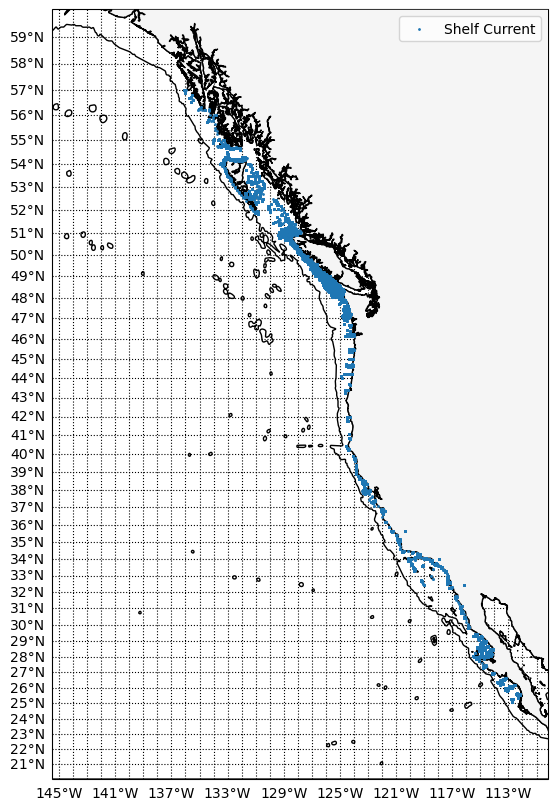

In [23]:
xlim, ylim = [-145.5, -110.2], [20, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=5))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=1))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=4)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

# and bathymetry
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'shelf'],obs['latitude (degrees_north)'][obs.current == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=6,label='Shelf Current')

ax.legend()

## CUC

In [24]:
# Separating CUC
densMin = 26.45 # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013, Sam Stevens personal communication
densMax = 26.6 # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
# depthMin = 175
# depthMax = 275

# Selecting data that is on the 26.5-26.6 isopycnal and where a current is over the continental slope
mask = ((obs['sigma0 (kg m-3)'] >= densMin) 
        & (obs['sigma0 (kg m-3)'] <= densMax) 
        # & (obs['depth (m)'] <= depthMax) # from Thomson & Krassovski 2010
        # & (obs['depth (m)'] >= depthMin) # from Thomson & Krassovski 2010
        & (obs['latitude (degrees_north)'] < 52) # from Meinvielle & Johnson 2013, bit further north to cover Queen Charlotte sound (evidence of CUC in Thomson & Krassovski, 2010)
        & (obs['latitude (degrees_north)'] > 25) # from Meinvielle & Johnson 2013
        & (obs['location'] == 'slope')) # from Meinvielle & Johnson 2013
obs.loc[mask, 'current'] = 'CUC'

obs_cuc = obs[obs['current'] == 'CUC']
obs_cuc

,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),spice,...,Co (nmol kg-1),Cu (nmol kg-1),Fe (nmol kg-1),Mn (nmol kg-1),Ni (nmol kg-1),Zn (nmol kg-1),source,current,geometry,location
2506,10545,1949-02-28 00:00:00+00:00,-118.17,32.67,250.0,251.921412,8.330000,34.256264,1027.662552,0.313749,...,NaN,NaN,NaN,NaN,NaN,NaN,CALCOFI,CUC,POINT (-118.17 32.67),slope
2507,10546,1949-02-28 00:00:00+00:00,-118.17,32.67,298.0,300.325447,7.800000,34.257222,1027.965052,0.229905,...,NaN,NaN,NaN,NaN,NaN,NaN,CALCOFI,CUC,POINT (-118.17 32.67),slope
2552,10591,1949-03-01 00:00:00+00:00,-124.08,38.83,285.0,287.369696,7.960000,34.147107,1027.795880,0.175768,...,NaN,NaN,NaN,NaN,NaN,NaN,CALCOFI,CUC,POINT (-124.08 38.83),slope
2553,10592,1949-03-01 00:00:00+00:00,-124.08,38.83,300.0,302.505476,7.770000,34.157444,1027.901718,0.153367,...,NaN,NaN,NaN,NaN,NaN,NaN,CALCOFI,CUC,POINT (-124.08 38.83),slope
2596,10635,1949-03-01 00:00:00+00:00,-119.52,32.05,250.0,251.908449,7.820000,34.215953,1027.709548,0.203321,...,NaN,NaN,NaN,NaN,NaN,NaN,CALCOFI,CUC,POINT (-119.52 32.05),slope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803964,3105027,2024-08-22 00:00:00+00:00,-124.95,44.37,0.0,0.000000,7.330787,34.121369,1026.555786,0.059917,...,NaN,NaN,NaN,NaN,NaN,NaN,ooi,CUC,POINT (-124.95 44.37),slope
1803978,3105049,2024-08-23 00:00:00+00:00,-124.95,44.37,0.0,0.000000,7.386125,34.138650,1026.561538,0.080728,...,NaN,NaN,NaN,NaN,NaN,NaN,ooi,CUC,POINT (-124.95 44.37),slope
1803993,3105072,2024-08-24 00:00:00+00:00,-124.95,44.37,0.0,0.000000,7.401760,34.117958,1026.543136,0.068228,...,NaN,NaN,NaN,NaN,NaN,NaN,ooi,CUC,POINT (-124.95 44.37),slope
1804008,3105095,2024-08-25 00:00:00+00:00,-124.95,44.37,0.0,0.000000,7.453199,34.119421,1026.537014,0.077114,...,NaN,NaN,NaN,NaN,NaN,NaN,ooi,CUC,POINT (-124.95 44.37),slope


In [25]:
# depth check 
np.mean(obs_cuc['depth (m)']) 
# reasonable!

np.float64(225.08393266165848)

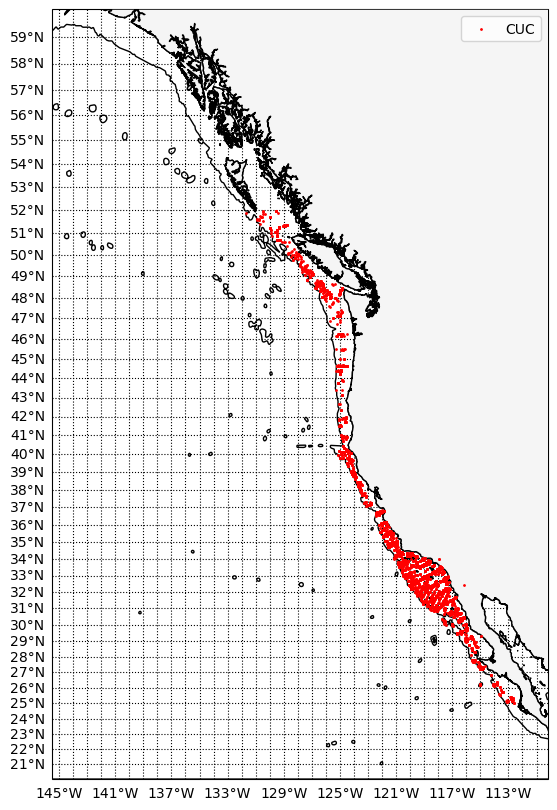

In [26]:
xlim, ylim = [-145.5, -110.2], [20, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=5))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=1))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=4)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

# and bathymetry
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=6,label='CUC')

ax.legend()

## CC

In [27]:
# Definition of CC based on Isopycnal and geography
def haversine(lat1, lon1, lat2, lon2):
    """
    Computes great-circle distance between two points on Earth (in km).
    """
    R = 6371.0  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

#checks if further than 100km from shore and closer than 1000km
def is_offshore100(lat, lon, coastline_geom, low_threshold_km=100, up_threshold_km=1000):
    point = Point(lon, lat)
    
    # Get nearest point on coastline boundary
    boundary = coastline_geom.boundary
    nearest_point = boundary.interpolate(boundary.project(point))
    
    # Use Haversine instead of geopy
    dist_km = haversine(lat, lon, nearest_point.y, nearest_point.x)
    return (dist_km > low_threshold_km) & (dist_km < up_threshold_km)

In [ ]:
max_lat = 50 # Auad et al

coastline = gpd.read_file('/ocean/ghoeven/MOAD/Data/ne_110m_land.shp')

# Define bounding box for area
bbox = box(-145.5, 20, -110.2, 60)  # lon_min, lat_min, lon_max, lat_max

# Clip the coastline to the bounding box
coastline_clipped = coastline[coastline.intersects(bbox)]
coastline_union = unary_union(coastline_clipped.geometry)

obs_copy = obs.copy()
obs_copy['is_offshore100'] = obs.apply(
    lambda row: is_offshore100(
        row['latitude (degrees_north)'],
        row['longitude (degrees_east)'],
        coastline_union
    ),
    axis=1
)

# --- extra offshore allowance between 45–50°N, farther offshore up to lon = -145.5E ---
lat = obs['latitude (degrees_north)']
lon = obs['longitude (degrees_east)']

base_offshore = obs_copy['is_offshore100']

# Points between 45–50°N, farther offshore (west) out to -145.5E
extra_offshore = (
    (lat >= 45) &
    (lat <= max_lat) &
    (lon >= -145.5) &
    (lon < -133) 
)

offshore_sel = base_offshore | extra_offshore

# Selecting data
mask = (
    (obs['current'] == '') &
    (lat <= max_lat) &                     # Auad et al
    (obs['sigma0 (kg m-3)'] <= 26.3) &     # Itoh & Rudnick 2017
    offshore_sel                           # distance-based OR far-offshore (45–50N)
)

obs.loc[mask, 'current'] = 'CC'
cc_obs = obs[obs['current'] == 'CC']

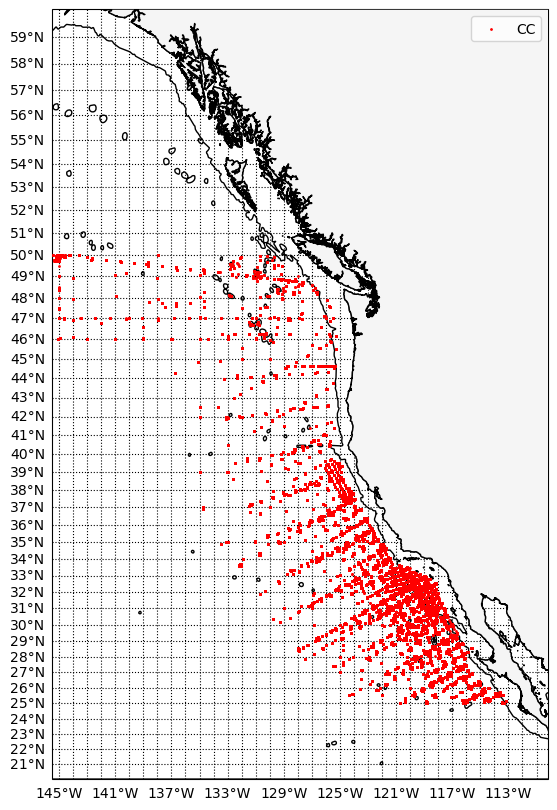

In [31]:
xlim, ylim = [-145.5, -110.2], [20, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=5))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=1))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=4)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

# and bathymetry
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CC'],obs['latitude (degrees_north)'][obs.current == 'CC'], c='r', transform=crs.PlateCarree(),s=1,zorder=6,label='CC')

ax.legend()

In [32]:
# depth check 
print(np.min(obs['depth (m)'][obs.current == 'CC']))
print(np.max(obs['depth (m)'][obs.current == 'CC']))
print(np.mean(obs['depth (m)'][obs.current == 'CC']))
# looks good to me!

0.0
500.0
72.76506189036564


(27.0, 36.0)

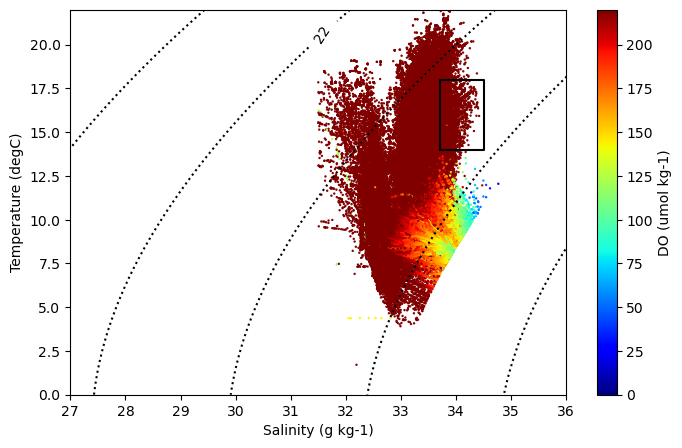

In [33]:
# T-S diagram of CC waters

# Setting up our grid and density contours
Temp = np.arange(0, 25, 0.2)
Sal = np.arange(18, 40, 0.4)
X,Y = np.meshgrid(Sal, Temp)
densZ = psu_tools.calculate_density(Y,X)-1000

fig, ax = plt.subplots(figsize=(8, 5))

cs = ax.contour(X,Y, densZ, levels=12, colors='k', linestyles='dotted')
ax.clabel(cs, cs.levels, fontsize=10)

sc = ax.scatter(cc_obs['salinity (g kg-1)'], cc_obs['temperature (degC)'], s=0.5, c=cc_obs['DO (umol kg-1)'], cmap='jet', alpha=1, vmin=0, vmax=220)
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='DO (umol kg-1)')

cc_square = np.array([[33.7, 14],
                     [33.7, 18],
                     [34.5, 18],
                     [34.5, 14],
                     [33.7, 14]])
ax.plot(cc_square[:,0], cc_square[:,1], c='k')
ax.set_xlabel('Salinity (g kg-1)')
ax.set_ylabel('Temperature (degC)')
ax.set_ylim([0,22])
ax.set_xlim([27,36])

/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/cart

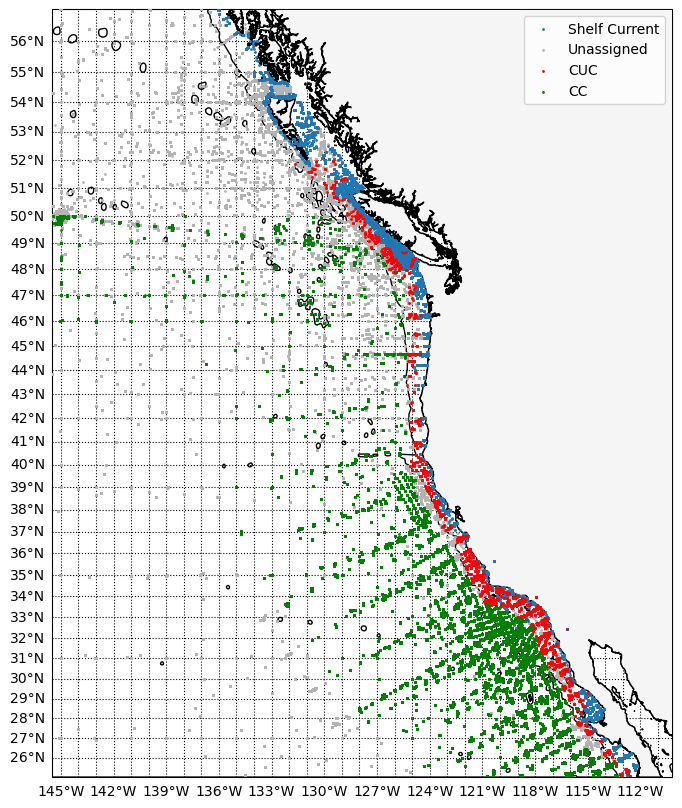

In [42]:
xlim, ylim = [-145.5, -110.2], [25, 57]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=5))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=1))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=4)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

# and bathymetry
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'shelf'],obs['latitude (degrees_north)'][obs.current == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=6,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=6,label='CUC')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CC'],obs['latitude (degrees_north)'][obs.current == 'CC'], c='g', transform=crs.PlateCarree(),s=1,zorder=6,label='CC')



ax.legend()

(30.0, 36.0)

/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


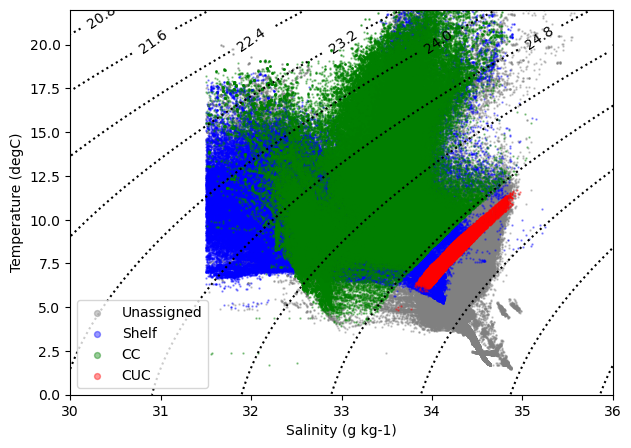

In [35]:
# T-S diagram of currents

# Setting up our grid and density contours
Temp = np.arange(0, 23, 0.2)
Sal = np.arange(30, 38, 0.4)
X,Y = np.meshgrid(Sal, Temp)
densZ = psu_tools.calculate_density(Y,X)-1000

fig, ax = plt.subplots(figsize=(7, 5))

cs = ax.contour(X,Y, densZ, levels=12, colors='k', linestyles='dotted')
ax.clabel(cs, cs.levels, fontsize=10)

ax.scatter(obs['salinity (g kg-1)'][obs.current == ''], obs['temperature (degC)'][obs.current == ''], s=0.5, c='grey', label='Unassigned', alpha=0.4)
ax.scatter(obs['salinity (g kg-1)'][obs.current == 'shelf'], obs['temperature (degC)'][obs.current == 'shelf'], s=0.5, c='b', label='Shelf', alpha=0.4)
ax.scatter(cc_obs['salinity (g kg-1)'], cc_obs['temperature (degC)'], s=0.5, c='g', label='CC', alpha=0.4)
ax.scatter(obs_cuc['salinity (g kg-1)'], obs_cuc['temperature (degC)'], s=0.5, c='r', label='CUC', alpha=0.4)

cc_square = np.array([[33.7, 14],
                     [33.7, 18],
                     [34.5, 18],
                     [34.5, 14],
                     [33.7, 14]])
# ax.plot(cc_square[:,0], cc_square[:,1], c='k', label='CC box?')
plt.legend(markerscale=6)
ax.set_xlabel('Salinity (g kg-1)')
ax.set_ylabel('Temperature (degC)')
ax.set_ylim([0,22])
ax.set_xlim([30,36])

In [36]:
obs.columns

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'density (kg m-3)', 'spice',
       'sigma0 (kg m-3)', 'DO (umol kg-1)', 'NO3 (uM)', 'NO2 (uM)', 'NH4 (uM)',
       'Nstar (umol kg-1)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)', 'TA (uM)',
       'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Cd (nmol kg-1)',
       'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'source', 'current', 'geometry',
       'location'],
      dtype='object')

In [37]:
obs['[TA-DIC] (uM)'] = obs['TA (uM)'] -  obs['DIC (uM)']

In [39]:
obs.drop(columns=['Unnamed: 0','geometry'],inplace=True)

In [40]:
# add year and month columns
obs['time'] = pd.to_datetime(obs['time'])

obs['year'] = obs.time.dt.year
obs['month'] = obs.time.dt.month

In [41]:
OUTPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'
obs.to_csv(OUTPATH)